In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib import rcParams
import plotly.express as px
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# For reproducibility
np.random.seed(1237)

import warnings
warnings.filterwarnings("ignore")

In [2]:
big_train_df = pd.read_csv('/content/drive/MyDrive/Data/fraud_detection/fraudTrain.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data/fraud_detection/fraudTest.csv')

big_train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
big_train_df["is_fraud"].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [4]:
train_df = big_train_df[big_train_df["is_fraud"] == 0].sample(frac = 0.2 , random_state = 45).append(big_train_df[big_train_df["is_fraud"] == 1])

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265340 entries, 885415 to 1295733
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             265340 non-null  int64  
 1   trans_date_trans_time  265340 non-null  object 
 2   cc_num                 265340 non-null  int64  
 3   merchant               265340 non-null  object 
 4   category               265340 non-null  object 
 5   amt                    265340 non-null  float64
 6   first                  265340 non-null  object 
 7   last                   265340 non-null  object 
 8   gender                 265340 non-null  object 
 9   street                 265340 non-null  object 
 10  city                   265340 non-null  object 
 11  state                  265340 non-null  object 
 12  zip                    265340 non-null  int64  
 13  lat                    265340 non-null  float64
 14  long                   265340 

In [5]:
train_df["is_fraud"].value_counts()

0    257834
1      7506
Name: is_fraud, dtype: int64

In [6]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
  df = df_input.copy()
  mapping = {x : node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + 
                                                           df["merchant"].values.tolist()))}
  df["from"]= df["cc_num"].apply(lambda x: mapping[x])
  df["to"]= df["merchant"].apply(lambda x: mapping[x])
  df = df [['from', 'to', "amt", "is_fraud"]].groupby (['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
  
  # print(df.describe())

  df["is_fraud"]= df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
  
  G = nx.from_edgelist(df[["from", "to"]].values, create_using = graph_type)
  print(graph_type)
  nx.set_node_attributes(G, {x:1 for x in df["from"].unique()}, "bipartite") 
  nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
  
  nx.set_edge_attributes(G,{(int (x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")
  nx.set_edge_attributes (G,{(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, "weight")

  return G


In [8]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
  df = df_input.copy()
  mapping = {x : node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                           df["cc_num"].values.tolist() + 
                                                           df["merchant"].values.tolist()))}
  df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
  df["out_node"]= df["merchant"].apply(lambda x: mapping[x])

  G = nx.from_edgelist([(x["in_node"], mapping [idx]) for idx, x in df.iterrows()] + 
                       [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()] , 
                        create_using = graph_type)

  nx.set_node_attributes (G, {x["in_node"]:1 for idx, x in df.iterrows()}, "bipartite") 
  nx.set_node_attributes (G, {x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
  nx.set_node_attributes (G, {mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

  nx.set_edge_attributes (G, {(x["in_node"], mapping [idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
  nx.set_edge_attributes (G, {(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

  nx.set_edge_attributes (G, {(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight") 
  nx.set_edge_attributes (G, {(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
  
  return G

In [7]:
G_bu = build_graph_bipartite(train_df , nx.Graph(name = 'Bipartite Undirected'))
G_bd = build_graph_bipartite(train_df , nx.DiGraph(name = 'Bipartite Directed'))
# G_tu = build_graph_tripartite(train_df , nx.Graph(name = 'Tripartite Undirected'))
# G_td = build_graph_tripartite(train_df , nx.DiGraph(name = 'Tripartite Directed'))

Graph with 1676 nodes and 201798 edges
DiGraph with 1676 nodes and 201798 edges


In [10]:
from networkx.algorithms import bipartite 
bipartite.is_bipartite(G_bu)


True

In [11]:
print(nx.info(G_bu))

Graph with 1676 nodes and 201798 edges


In [12]:
!pip install python-louvain

In [13]:
from community import community_louvain

parts = community_louvain.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

3     515
8     267
1     253
6     159
9     142
2     106
4      90
7      64
10     45
0      32
5       3
dtype: int64

In [14]:
communities.value_counts().sum()

1676

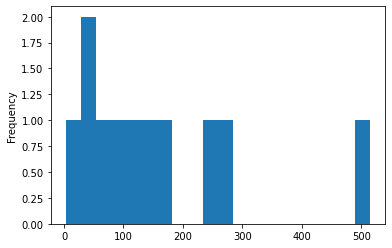

In [15]:
communities.value_counts().plot.hist(bins = 20);

In [16]:
#Ratio of fraudulent / benign nodes in Communities Detected

graphs = []
d = {}
for x in communities.unique():
  tmp = nx.subgraph(G_bu, communities[communities==x].index)
  fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
  ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
  d[x] = ratio
  graphs += [tmp]

pd.Series (d).sort_values (ascending=False)

0     25.882353
10    24.691358
7     21.505376
9     21.369103
4     18.794326
2     17.428571
6     15.991471
8      3.646666
1      2.162064
3      1.909464
5      0.000000
dtype: float64

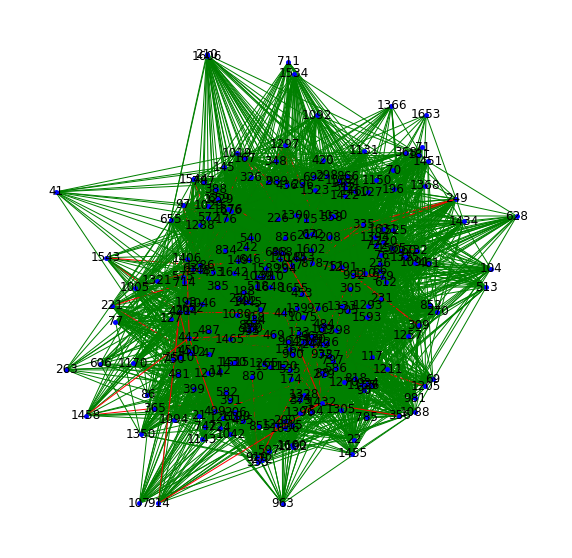

In [17]:
#Fraudulent Edges in each community ID

gId = 1
plt.figure(figsize = (10, 10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], "label").values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color = 'b', edge_color=edge_colors, with_labels=True, node_size=15)

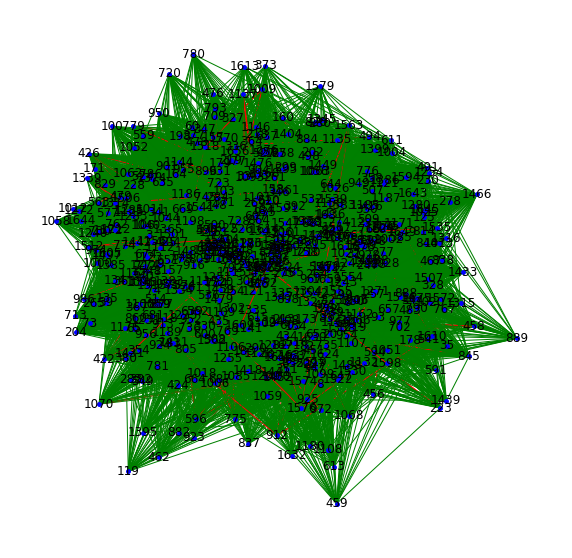

In [18]:
#Fraudulent Edges in each community ID

gId = 3
plt.figure(figsize = (10, 10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], "label").values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color = 'b', edge_color=edge_colors, with_labels=True, node_size=15)

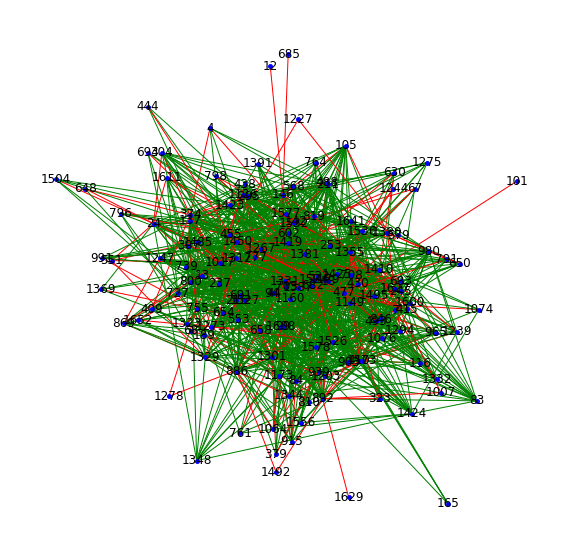

In [19]:
#Fraudulent Edges in each community ID

gId = 7
plt.figure(figsize = (10, 10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], "label").values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color = 'b', edge_color=edge_colors, with_labels=True, node_size=15)

In [8]:
from sklearn.utils import resample

df_majority = train_df[train_df.is_fraud==0]
df_minority= train_df[train_df.is_fraud==1]

df_maj_dowsampled= resample(df_majority, n_samples=len(df_minority), random_state=42)
df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts()) 
G_down = build_graph_bipartite(df_downsampled)

1    7506
0    7506
Name: is_fraud, dtype: int64
Graph with 1673 nodes and 14618 edges


In [9]:
from sklearn.model_selection import train_test_split

train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))),
                                                                      list(nx.get_edge_attributes(G_down, "label").values()),
                                                                      test_size=0.20,
                                                                      random_state = 42)

In [10]:
!pip install node2vec
!pip install python-Levenshtein

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5978 sha256=96d788e245c9c03bad98322dbf9ef3ea775a62ba70218efe6b49ff6a5e0d591b
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec
     |████████████████████████████████| 50 kB 6.2 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149861 sha256=0857ede46e908b8d5829c349b92ee5524c03a4ada4b9892c3318ddf33d32dbdb
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [11]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(G_down, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Computing transition probabilities:   0%|          | 0/1673 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:00<00:00,  6.05s/it]


In [12]:
edgs = G_down.edges
edgs

EdgeView([(0, 229), (0, 578), (0, 787), (0, 1454), (0, 1507), (0, 1514), (0, 1545), (0, 1641), (229, 90), (229, 101), (229, 456), (229, 518), (229, 648), (229, 802), (229, 1240), (229, 1253), (229, 1657), (578, 206), (578, 557), (578, 658), (578, 757), (578, 802), (578, 1203), (578, 1238), (578, 1300), (578, 1500), (578, 1601), (787, 168), (787, 221), (787, 446), (787, 647), (787, 996), (787, 1311), (787, 1560), (1454, 4), (1454, 27), (1454, 59), (1454, 165), (1454, 414), (1454, 420), (1454, 460), (1454, 463), (1454, 475), (1454, 551), (1454, 730), (1454, 782), (1454, 818), (1454, 877), (1454, 901), (1454, 981), (1454, 984), (1454, 989), (1454, 1096), (1454, 1111), (1454, 1115), (1454, 1135), (1454, 1161), (1454, 1209), (1454, 1260), (1454, 1290), (1454, 1306), (1454, 1326), (1454, 1344), (1454, 1346), (1454, 1349), (1454, 1401), (1454, 1445), (1454, 1457), (1454, 1469), (1454, 1472), (1454, 1487), (1454, 1512), (1454, 1526), (1454, 1541), (1454, 1548), (1454, 1560), (1454, 1611), (150

In [19]:

edgs = np.asarray(edgs)
edgs

array([[   0,  229],
       [   0,  578],
       [   0,  787],
       ...,
       [ 176, 1245],
       [ 176, 1417],
       [ 176, 1588]])

In [38]:
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
  embeddings_train = cl(keyed_vectors = model_train.wv)
  train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges] 
  test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
  rf = RandomForestClassifier (n_estimators=1000, random_state=42)
  rf.fit(train_embeddings, train_labels);
  
  y_pred = rf.predict(test_embeddings)
  
  print(cl)
  print('Precision:', metrics.precision_score (test_labels, y_pred))

  print ('Recall:', metrics.recall_score(test_labels, y_pred))

  print('F1-Score:', metrics.f1_score(test_labels, y_pred))

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.80370942812983
Recall: 0.6989247311827957
F1-Score: 0.7476635514018691
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7312119160460393
Recall: 0.7258064516129032
F1-Score: 0.7284991568296796
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.8010878010878011
Recall: 0.6928763440860215
F1-Score: 0.743063063063063
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.7972560975609756
Recall: 0.7029569892473119
F1-Score: 0.7471428571428571


In [15]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from sklearn import metrics
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [37]:
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
  embeddings_train = cl(keyed_vectors = model_train.wv)
  train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges] 

  print(np.asarray(train_embeddings).shape)
  model = Sequential()
  model.add(Dense(128, input_shape=(128,)))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(Dense(64))
  model.add(Activation('relu'))
  # model.add(Dropout(0.3))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  # model.summary()

  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  model.fit(np.asarray(train_embeddings), np.asarray(train_labels),
                    batch_size=64,
                    shuffle = True,
                    epochs=50,
                    verbose=2,
                    callbacks=[callback],
                    validation_split=0.1)


  test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
  y_pred = model.predict(np.asarray(test_embeddings))
  y_pred = [1 if x > 0.5 else 0 for x in y_pred]
  
  print(cl)
  print('Precision:', metrics.precision_score (test_labels, y_pred))

  print ('Recall:', metrics.recall_score(test_labels, y_pred))

  print('F1-Score:', metrics.f1_score(test_labels, y_pred))


(11694, 128)
Epoch 1/50
165/165 - 1s - loss: 0.6608 - accuracy: 0.6177 - val_loss: 0.6293 - val_accuracy: 0.6573 - 1s/epoch - 6ms/step
Epoch 2/50
165/165 - 0s - loss: 0.6046 - accuracy: 0.6873 - val_loss: 0.6003 - val_accuracy: 0.6829 - 382ms/epoch - 2ms/step
Epoch 3/50
165/165 - 0s - loss: 0.5640 - accuracy: 0.7251 - val_loss: 0.5745 - val_accuracy: 0.7154 - 452ms/epoch - 3ms/step
Epoch 4/50
165/165 - 0s - loss: 0.5281 - accuracy: 0.7502 - val_loss: 0.5596 - val_accuracy: 0.7179 - 432ms/epoch - 3ms/step
Epoch 5/50
165/165 - 0s - loss: 0.4940 - accuracy: 0.7714 - val_loss: 0.5477 - val_accuracy: 0.7333 - 451ms/epoch - 3ms/step
Epoch 6/50
165/165 - 0s - loss: 0.4716 - accuracy: 0.7814 - val_loss: 0.5427 - val_accuracy: 0.7333 - 365ms/epoch - 2ms/step
Epoch 7/50
165/165 - 0s - loss: 0.4511 - accuracy: 0.7954 - val_loss: 0.5409 - val_accuracy: 0.7376 - 453ms/epoch - 3ms/step
Epoch 8/50
165/165 - 0s - loss: 0.4356 - accuracy: 0.8045 - val_loss: 0.5418 - val_accuracy: 0.7350 - 414ms/epoch -

In [53]:
def concat_emb(node1 , node2):
  return (np.concatenate((node1, node2), axis=0)).T

In [49]:
model_train.wv["100"].shape

(128,)

In [13]:
def new_emb(node1 , node2):
  temp = (np.concatenate((node1, node2), axis=0))
  temp2 = (node1-node2)**2
  return (np.concatenate((temp, temp2), axis=0)).T

In [20]:
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
classes = 1
for cl in range(1):
  # embeddings_train = cl(keyed_vectors = model_train.wv)
  train_embeddings = [new_emb(np.asarray(model_train.wv[str(edgs[x][0])]).reshape(-1),
                                 np.asarray(model_train.wv[str(edgs[x][1])]).reshape(-1)) for x in train_edges] 

  test_embeddings =  [new_emb(np.asarray(model_train.wv[str(edgs[x][0])]).reshape(-1),
                                 np.asarray(model_train.wv[str(edgs[x][1])]).reshape(-1)) for x in test_edges]
 
  rf = RandomForestClassifier (n_estimators=1000, random_state=42)
  rf.fit(train_embeddings, train_labels);
  
  y_pred = rf.predict(test_embeddings)
  
  print(cl)
  print('Precision:', metrics.precision_score (test_labels, y_pred))

  print ('Recall:', metrics.recall_score(test_labels, y_pred))

  print('F1-Score:', metrics.f1_score(test_labels, y_pred))


0
Precision: 0.7736263736263737
Recall: 0.7313019390581718
F1-Score: 0.7518689925240299


In [65]:
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
classes = 1
for cl in range(1):
  # embeddings_train = cl(keyed_vectors = model_train.wv)
  train_embeddings = [new_emb(np.asarray(model_train.wv[str(edgs[x][0])]).reshape(-1),
                                 np.asarray(model_train.wv[str(edgs[x][1])]).reshape(-1)) for x in train_edges] 

  print(np.asarray(train_embeddings).shape)
  model = Sequential()
  model.add(Dense(256, input_shape=(384,)))
  model.add(Activation('relu'))
  # model.add(Dropout(0.4))
  model.add(Dense(128))
  model.add(Activation('relu'))
  # model.add(Dropout(0.3))
  model.add(Dense(32))
  model.add(Activation('relu'))
  # model.add(Dropout(0.3))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  # model.summary()

  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  model.fit(np.asarray(train_embeddings), np.asarray(train_labels),
                    batch_size=64,
                    shuffle = True,
                    epochs=50,
                    verbose=2,
                    callbacks=[callback],
                    validation_split=0.15)


  test_embeddings = [new_emb(np.asarray(model_train.wv[str(edgs[x][0])]).reshape(-1),
                                 np.asarray(model_train.wv[str(edgs[x][1])]).reshape(-1)) for x in test_edges]
  y_pred = model.predict(np.asarray(test_embeddings))
  y_pred = [1 if x > 0.5 else 0 for x in y_pred]
  
  print(cl)
  print('Precision:', metrics.precision_score (test_labels, y_pred))

  print ('Recall:', metrics.recall_score(test_labels, y_pred))

  print('F1-Score:', metrics.f1_score(test_labels, y_pred))


(11694, 384)
Epoch 1/50
156/156 - 1s - loss: 0.5485 - accuracy: 0.7280 - val_loss: 0.4896 - val_accuracy: 0.7766 - 1s/epoch - 9ms/step
Epoch 2/50
156/156 - 1s - loss: 0.4253 - accuracy: 0.8145 - val_loss: 0.4531 - val_accuracy: 0.8017 - 653ms/epoch - 4ms/step
Epoch 3/50
156/156 - 1s - loss: 0.3344 - accuracy: 0.8631 - val_loss: 0.4471 - val_accuracy: 0.7943 - 613ms/epoch - 4ms/step
Epoch 4/50
156/156 - 1s - loss: 0.2294 - accuracy: 0.9120 - val_loss: 0.4892 - val_accuracy: 0.8091 - 636ms/epoch - 4ms/step
Epoch 5/50
156/156 - 1s - loss: 0.1331 - accuracy: 0.9531 - val_loss: 0.6291 - val_accuracy: 0.8028 - 605ms/epoch - 4ms/step
0
Precision: 0.8443465491923642
Recall: 0.7728494623655914
F1-Score: 0.8070175438596492
